In [6]:
import cufflinks as cf
import pandas as pd
import plotly.offline as py

In [7]:
import yfinance as yf

df_aapl = yf.download("AAPL", start="2023-01-01", end="2023-12-31", group_by="ticker")
df_aapl.dropna(inplace=True)

# Flatten MultiIndex columns
df_aapl.columns = df_aapl.columns.get_level_values(1)

# Now columns are: ['Open', 'High', 'Low', 'Close', 'Volume']



/var/folders/32/x9dgly0d26z5yqyvl8t2zw3c0000gn/T/ipykernel_10974/2494099814.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [8]:
import cufflinks as cf
import pandas as pd
import plotly.offline as py
qf = cf.QuantFig(df_aapl, title="AAPL stock price", legend='top', name='AAPL') # input

qf.add_volume()
qf.add_sma(periods = 20, column = 'Close', color = 'red')
qf.add_ema(periods = 20, color = 'green')
qf.iplot()

In [58]:
import yfinance as yf
import backtrader as bt
from datetime import datetime

# 1. Download data with yfinance
df = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
# Fix MultiIndex columns (likely from downloading with multiple levels)
# Flatten MultiIndex columns by taking the first level (e.g. 'Close')
df.columns = [col[0].lower() for col in df.columns]

# Confirm success
print(df.columns)


# 2. Define PandasData feed
class PandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', -1),
    )

data = PandasData(dataname=df)

# 3. Use your strategy/signal setup as before
class SmaSignal(bt.Signal):
    params = (('period', 20), )

    def __init__(self):
        sma = bt.ind.SMA(self.data, period=self.p.period)
        self.lines.signal = bt.ind.CrossOver(self.data, sma)

cerebro = bt.Cerebro(stdstats=False)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
cerebro.run()
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
cerebro.plot(iplot = True, volume = False)


/var/folders/32/x9dgly0d26z5yqyvl8t2zw3c0000gn/T/ipykernel_51690/450031725.py:6: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Index(['close', 'high', 'low', 'open', 'volume'], dtype='object')
Starting Portfolio Value: 1000.00
Final Portfolio Value: 1045.51


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 3 Axes>]]

In [59]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        self.data_close = self.datas[0].close

        self.order = None
        self.price = None
        self.comm = None

        self.sma = bt.ind.SMA(self.datas[0],
                              period = self.params.ma_period)
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"SELL EXECUTED --- Price: {order.executed.price:.2f}, \
                Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}")

                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f"SELL EXECUTED --- Price: {order.executed.price:.2f}, "
                  f"Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}")

                self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin,
                              order.Rejected]:
            self.log('Order Failed')
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f"OPERATION RESULT --- Gross: {trade.pnl:.2f},\
                  Net: {trade.pnlcomm:.2f}")
    def next(self):
        if self.order:
            return  # Skip if an order is pending

        if not self.position:
             # BUY signal: price crosses above SMA
             if self.data_close[0] > self.sma[0] and self.data_close[-1] <= self.sma[-1]:
                  self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                  self.order = self.buy()
        else:
             # SELL signal: price crosses below SMA
             if self.data_close[0] < self.sma[0] and self.data_close[-1] >= self.sma[-1]:
                  self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                  self.order = self.sell()
cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

print(f"Starting Portfolio Value: {cerebro.broker.get_value():.2f}")
cerebro.run()
print(f"Final Portfolio Value: {cerebro.broker.get_value():.2f}")

cerebro.plot(iplot = True, volume = False)

Starting Portfolio Value: 1000.00
2023-03-03, BUY CREATED --- Price: 149.33
2023-03-06, SELL EXECUTED --- Price: 152.06,                 Cost: 152.06, Commission: 0.00
2023-03-10, SELL CREATED --- Price: 146.82
2023-03-13, SELL EXECUTED --- Price: 146.14, Cost: 152.06, Commission: 0.00
2023-03-13, OPERATION RESULT --- Gross: -5.91,                  Net: -5.91
2023-03-13, BUY CREATED --- Price: 148.77
2023-03-14, SELL EXECUTED --- Price: 149.57,                 Cost: 149.57, Commission: 0.00
2023-04-12, SELL CREATED --- Price: 158.29
2023-04-13, SELL EXECUTED --- Price: 159.81, Cost: 149.57, Commission: 0.00
2023-04-13, OPERATION RESULT --- Gross: 10.23,                  Net: 10.23
2023-04-13, BUY CREATED --- Price: 163.69
2023-04-14, SELL EXECUTED --- Price: 162.73,                 Cost: 162.73, Commission: 0.00
2023-04-25, SELL CREATED --- Price: 161.92
2023-04-26, SELL EXECUTED --- Price: 161.22, Cost: 162.73, Commission: 0.00
2023-04-26, OPERATION RESULT --- Gross: -1.51,           

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 2 Axes>]]

In [36]:
import backtrader as bt
import datetime
import pandas as pd

class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2.0),)
    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/ buy price/ buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add Bollinger Bands indicator and track buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0],
                                            period = self.p.period,
                                            devfactor = self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0],
                                           self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0],
                                            self.b_band.lines.top)

    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}, {txt}")
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f"BUY EXECUTED --- PRICE: {order.executed.price:.2f}, \
                     Cost: {order.executed.value:.2f},  Commission:{order.executed.comm:.2f}"
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f"SELL EXECUTED --- Price: {order.executed.price:.2d}, \
                     Cost: {order.executed.value:.2f}, Commission {order.executed.comm}")
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')
        self.order = None

    def  notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATON RESULT --- Gross: {trade.pnl:.2f}, \
                  Net: {trade.pnlcomm:.2f}')
    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                size = int(self.broker.getcash()/ self.datas[0].open)
                self.log(f"BUY CREATED --- Size: {size}, Cash:{self.broker.getcash():.2f},\
                         Open:{self.data.open[0]}, Close:{self.data_close[0]}")
                self.buy(size = size)
            else:
                if self.sell_signal < 0:
                    self.log(f'SELL CREATED --- Size: {self.position.size}')
                    self.sell(size = self.position.size)



In [37]:
import yfinance as yf
import backtrader as bt
from datetime import datetime

# 1. Download data with yfinance
df = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
# Fix MultiIndex columns (likely from downloading with multiple levels)
# Flatten MultiIndex columns by taking the first level (e.g. 'Close')
df.columns = [col[0].lower() for col in df.columns]

# Confirm success
print(df.columns)


# 2. Define PandasData feed
class PandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', -1),
    )

data = PandasData(dataname=df)

/var/folders/32/x9dgly0d26z5yqyvl8t2zw3c0000gn/T/ipykernel_10974/1178828352.py:6: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Index(['close', 'high', 'low', 'open', 'volume'], dtype='object')


Starting Portfolio Value: 10000.00
2023-02-07, SELL CREATED --- Size: 0
2023-03-23, SELL CREATED --- Size: 0
2023-04-04, SELL CREATED --- Size: 0
2023-05-02, SELL CREATED --- Size: 0
2023-05-10, SELL CREATED --- Size: 0
2023-06-06, SELL CREATED --- Size: 0
2023-07-05, SELL CREATED --- Size: 0
2023-08-11, BUY CREATED --- Size: 56, Cash:10000.00,                         Open:175.7993034466227, Close:176.2652587890625
2023-08-11, BUY EXECUTED --- PRICE: 175.80,                      Cost: 9844.76,  Commission:9.84
Final Portfolio Value: 10848.69


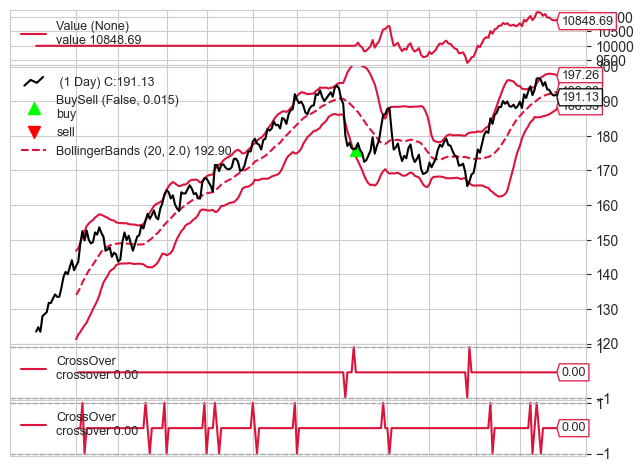

[[<Figure size 640x480 with 4 Axes>]]

In [44]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open = True)

cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission = 0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name = 'returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name = 'time_return')


print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

%matplotlib inline

cerebro.plot(iplot = False, volume = False)

In [47]:
# Inspection
backtest_result[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 0.08145946947882503),
             ('ravg', 0.0003258378779153001),
             ('rnorm', 0.08557645977494993),
             ('rnorm100', 8.557645977494992)])

<Axes: title={'center': 'Portfolio Daily Returns'}, xlabel='report_date'>

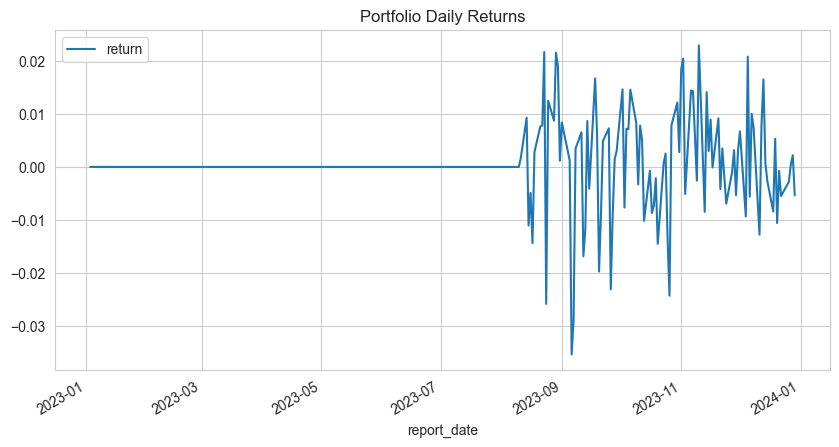

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `backtest_result` is the result of `cerebro.run()`
# and time_return analyzer is attached properly

# Extract daily returns
return_dict = backtest_result[0].analyzers.time_return.get_analysis()

# Convert to DataFrame
return_df = pd.DataFrame(list(return_dict.items()),
                         columns=['report_date', 'return']).set_index('report_date')

# Plot
return_df.plot(title='Portfolio Daily Returns', figsize=(10, 5), grid=True)


In [13]:
data